In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

sns.set()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

100% 25.7M/25.7M [00:01<00:00, 32.1MB/s]
100% 25.7M/25.7M [00:01<00:00, 21.0MB/s]


In [4]:
from zipfile import ZipFile
dataset = '/content/imdb-dataset-of-50k-movie-reviews.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()

In [5]:
imdb = pd.read_csv('/content/IMDB Dataset.csv')

In [6]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
imdb.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [8]:
text = imdb['review'][0]
print(text)
print(word_tokenize(text))

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [9]:
corpus = []
for text in imdb['review']:
  words = [word.lower() for word in word_tokenize(text)]
  corpus.append(words)

In [10]:
numwords = len(corpus)
print(numwords)

50000


In [32]:
train_size = int(imdb.shape[0] * 0.8)
X_train = imdb.review[:train_size]
Y_train = imdb.sentiment[:train_size]

X_test = imdb.review[train_size:]
Y_test = imdb.sentiment[train_size:]

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = 128, truncating = 'post', padding = 'post')

In [34]:
print(X_train[0])
print(len(X_train[0]))

[   27     4     1    80  2102    45  1073    12   100   147    39   316
  2968   409   459    26  3173    33    23   200    14    11     6   614
    48   606    16    68     7     7     1    87   148    12  3256    68
    41  2968    13    92  5626     2 16202   134     4   569    60   271
     8   200    36     1   673   139  1712    68    11     6    21     3
   118    15     1  7870  2257    38 11540    11   118  2495    54  5662
    16  5182     5  1438   377    38   569    92     6  3730     8     1
   360   353     4     1   673     7     7     9     6   431  2968    14
    12     6     1 11736   356     5     1 14689  6526  2594  1087 51144
     9  2661  1432    20 22583   534    32  4795  2451     4     1  1193
   117    29     1  6893    25  2874 12191     2]
128


In [35]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = 128, truncating = 'post', padding = 'post')

In [36]:
LE = LabelEncoder()

In [37]:
Y_test

40000    negative
40001    negative
40002    negative
40003    negative
40004    negative
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 10000, dtype: object

In [38]:
Y_train = LE.fit_transform(Y_train)
Y_test = LE.transform(Y_test)

In [40]:
model = Sequential()
model.add(Embedding(input_dim = numwords, output_dim = 100, input_length = 128, trainable = True))
model.add(LSTM(100, dropout = 0.1, return_sequences = True))
model.add(LSTM(100, dropout = 0.1))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 100)          5000000   
                                                                 
 lstm_2 (LSTM)               (None, 128, 100)          80400     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,160,901
Trainable params: 5,160,901
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(X_train, Y_train, batch_size = 64, validation_data = (X_test, Y_test), epochs = 5)

Epoch 1/5
625/625 [==============================] - 80s 114ms/step - loss: 0.4431 - accuracy: 0.7949 - val_loss: 0.3651 - val_accuracy: 0.8528
Epoch 2/5
625/625 [==============================] - 27s 43ms/step - loss: 0.2497 - accuracy: 0.9050 - val_loss: 0.3573 - val_accuracy: 0.8475
Epoch 3/5
625/625 [==============================] - 15s 24ms/step - loss: 0.1640 - accuracy: 0.9416 - val_loss: 0.4433 - val_accuracy: 0.8531
Epoch 4/5
625/625 [==============================] - 12s 20ms/step - loss: 0.1120 - accuracy: 0.9613 - val_loss: 0.4651 - val_accuracy: 0.8406
Epoch 5/5
625/625 [==============================] - 12s 20ms/step - loss: 0.0809 - accuracy: 0.9748 - val_loss: 0.5498 - val_accuracy: 0.8413


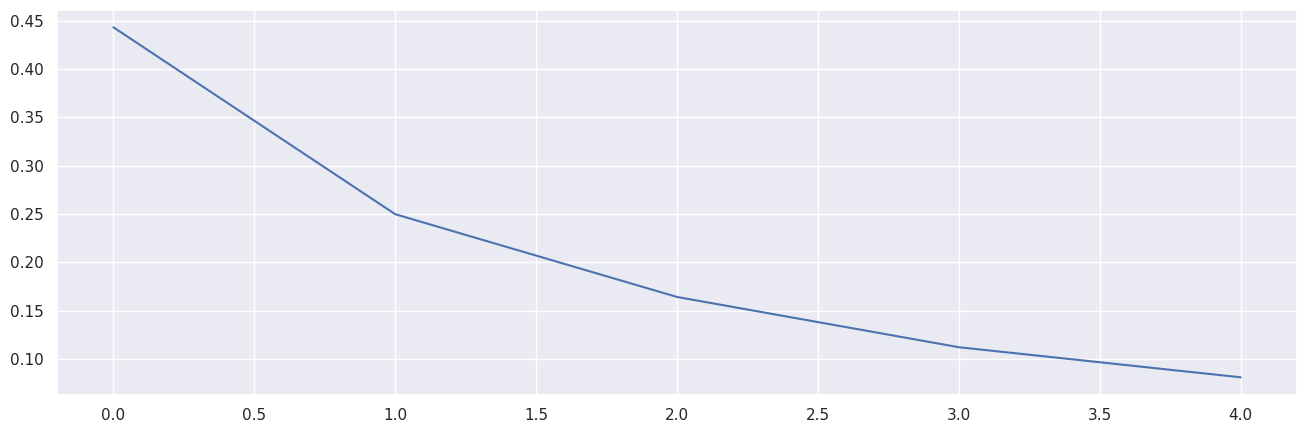

In [44]:
plt.figure(figsize = (16,5))
plt.plot(history.history['loss'])

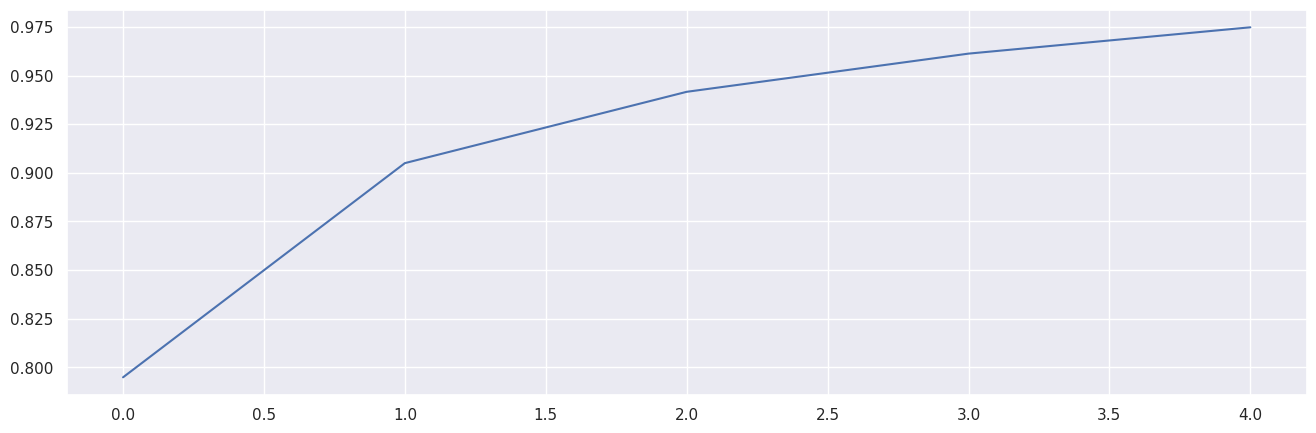

In [45]:
plt.figure(figsize = (16,5))
plt.plot(history.history['accuracy'])

In [46]:
val_sentence = ['I can watch this movie forever because of the beauty in its cinematography.']
sen_tokened = tokenizer.texts_to_sequences(val_sentence)
sen_paddened = pad_sequences(sen_tokened, maxlen = 128, truncating = 'post', padding = 'post')
print(val_sentence[0])
print("Probability of positive : {}".format(model.predict(sen_paddened)[0]))

I can watch this movie forever because of the beauty in its cinematography.
1/1 [==============================] - 1s 1s/step
Probability of positive : [0.99076754]


In [47]:
val_sentence = ['Horrible movie, would not recommend it even to my worst enemy, god bless my eyes.']
sen_tokened = tokenizer.texts_to_sequences(val_sentence)
sen_paddened = pad_sequences(sen_tokened, maxlen = 128, truncating = 'post', padding = 'post')
print(val_sentence[0])
print("Probability of positive : {}".format(model.predict(sen_paddened)[0]))

Horrible movie, would not recommend it even to my worst enemy, god bless my eyes.
1/1 [==============================] - 0s 21ms/step
Probability of positive : [0.0111074]
